In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.utils.data as data
import pytorch_lightning as pl

# MNIST Dataset 불러오기, 확인 및 분할

In [2]:
train_set = MNIST(os.getcwd(), download=True, train=True, transform=transforms.ToTensor())
test_set = MNIST(os.getcwd(), download=True, train=False, transform=transforms.ToTensor())

train_set_size = int(len(train_set) * 0.8)
valid_set_size = len(train_set) - train_set_size

# 8 : 2 비율로 train_set과 valid_set 분할
train_set, valid_set = data.random_split(train_set, [train_set_size, valid_set_size])

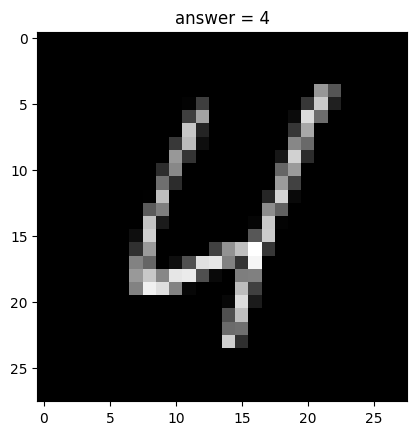

In [3]:
image, label = train_set[0]
image = image.numpy()
image = image.squeeze()  # 차원 축소

# 이미지 시각화
plt.imshow(image, cmap='gray')
plt.title(f"answer = {label}")
plt.show()

In [4]:
# DataLoader 변환
train_loader = data.DataLoader(train_set)
valid_loader = data.DataLoader(valid_set)
test_loader = data.DataLoader(test_set)

##  PyTorch nn.Modules를 이용해서 이미지에 대한 Encoder 및 Decoder 선언

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))

    def forward(self, x):
        return self.l1(x)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))

    def forward(self, x):
        return self.l1(x)


## LightningModule 선언

In [6]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, _ = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        return loss

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, _ = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        val_loss = F.mse_loss(x_hat, x)
        self.log("val_loss", val_loss)
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, _ = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = F.mse_loss(x_hat, x)
        self.log("test_loss", test_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [7]:
# model
model = LitAutoEncoder(Encoder(), Decoder())

In [9]:
trainer = pl.Trainer(accelerator="auto", devices="auto")
trainer.fit(model, train_loader, valid_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\hg\github\blog_code\.venv\Lib\site-packages\pytorch_lightning\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 50.4 K | train
1 | decoder | Decoder | 51.2 K | train
--------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\hg\github\blog_code\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\Users\hg\github\blog_code\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\hg\github\blog_code\.venv\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
trainer.test(model, dataloaders=test_loader)